# Frequency Demixer: ‘Unwanted Solo’

Sample Rate: 48000 Hz
Duration: 15.00 seconds


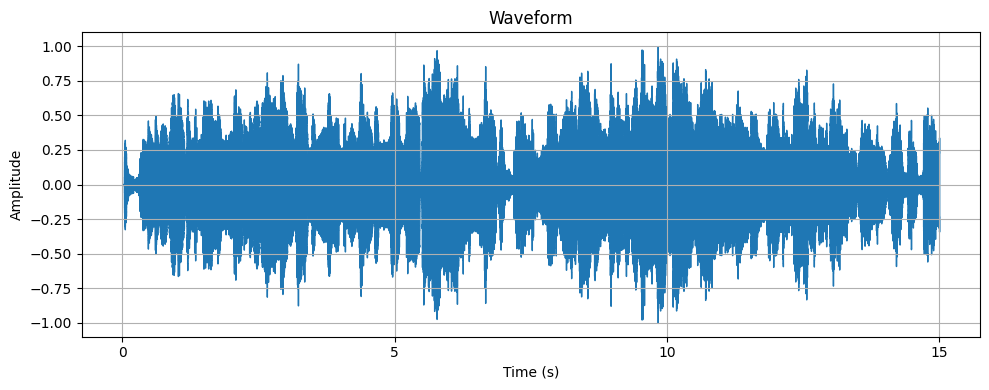

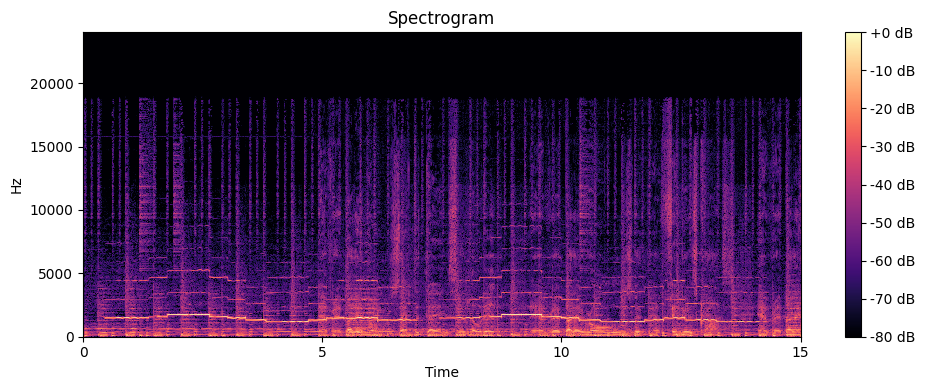

In [2]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch, freqz, butter, filtfilt, tf2zpk

from scipy.fft import fft, ifft, fftfreq
import soundfile as sf
# 1. Load the audio file
audio_path = 'song_with_2piccolo.wav'
y, sr = librosa.load(audio_path, sr=None) # sr stands for sampling rate

# 2. Print sampling rate and duration
print(f"Sample Rate: {sr} Hz")
print(f"Duration: {len(y) / sr:.2f} seconds")

# 3. Normalize audio
y_normalized = y / np.max(np.abs(y))

# 4. Plot the waveform
plt.figure(figsize=(10, 4))
librosa.display.waveshow(y_normalized, sr=sr)
plt.title("Waveform")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.tight_layout()
plt.show()

# 5. Plot the spectrogram (in dB)
D = librosa.stft(y)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

plt.figure(figsize=(10, 4))
librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='hz', cmap='magma')
plt.colorbar(format="%+2.0f dB")
plt.title("Spectrogram")
plt.tight_layout()
plt.show()

Above graph shows **Waveform** and **Spectogram** of unfilterd signal.

In spectrogram we can observe some vertical strands suggesting unwanted frequency or noise

We will use various filters like Butterworth Bandstop filter, notch filter to filter our song.

### Analysis of Power spectral density (PSD) 

It tells us how the power of a sound signal is distributed across different frequencies, enabling targeted filtering of specific frequency ranges
We will use it to remove certain frequency to filter out the song

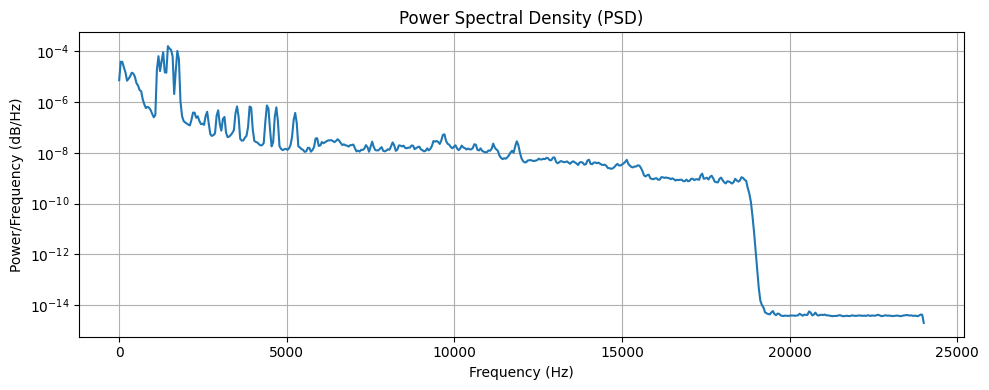

In [3]:
f, Pxx = welch(y_normalized, sr, nperseg=1024)

plt.figure(figsize=(10, 4))
plt.semilogy(f, Pxx)
plt.title("Power Spectral Density (PSD)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power/Frequency (dB/Hz)")
plt.grid(True)
plt.tight_layout()
plt.show()

**Observation**: In the Power Spectral Density (PSD) plot above, we can see sharp energy peaks between 1000 Hz and 2000 Hz, which indicates the unwanted noise which needs to be attenuated, so to remove this, I designed a Butterworth band-stop filter targeting this 1000–2000 Hz range.

### Butterworth Bandstop filter

- A band-stop filter is designed to attenuate a specific frequency range while allowing frequencies outside that range to pass through with minimal attenuation.
- The Butterworth filter is known for its maximally flat frequency response in the passband

The transfer function of an analog Butterworth filter is given by:

$$
|H(j\omega)|^2 = \frac{1}{1 + \left( \frac{\omega}{\omega_c} \right)^{2n}}
$$

- $\omega$ is the angular frequency
- $\omega_c$  is the cutoff frequency
- n is the filter order: We have take order n = 4 inour filter designing


The reason I took the n = 4 as the vocal is more clear. I have tried taking n= 2 but it was not so clear.


#### Normalizing frequency 

For using `scipy.signal.butter`, the frequency values to make a filter must be in range:

$$
0 < f_{\text{norm}} < 1
$$

$$
\text{low} = \frac{f_{\text{low}}}{f_{\text{Nyq}}}, \quad \text{high} = \frac{f_{\text{high}}}{f_{\text{Nyq}}}
$$

where,

$$
f_{\text{Nyq}} = \frac{f_s}{2}
$$

In [23]:
def butter_bandstop(lowcut, highcut, fs, order=6):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='bandstop')
    return b, a


In [24]:


lowcut = 1000
highcut = 2000
b, a = butter_bandstop(lowcut, highcut, sr, order=4)  

# Applying filter filter
y_butter_filtered = filtfilt(b, a, y_normalized) 

### Pole zero plot of the Butterworth Bandstop filter 

We have design the filter to supress the frequency from 1000Hz to 2000 Hz, we will observe its pole zero plot to see how filter is working.

Transfer function of the Filter: 
$$
H(z) = \frac{B(z)}{A(z)}= \frac{b_0 + b_1 z^{-1} + \cdots + b_N z^{-N}}{1 + a_1 z^{-1} + \cdots + a_M z^{-M}}
$$

in factor form:

$$H(z) = k \cdot \frac{(z - z_1)(z - z_2)\dots(z - z_N)}{(z - p_1)(z - p_2)\dots(z - p_M)}$$
where,
- $z_i$ : zeros
- $p_i$ : poles
- $k$ : constant


#### Observation from Pole-Zero Plot
* Zeros are on the unit circle at angle corresponding to frequencies 1000Hz to 2000Hz which succesfully supress the frequency in that range.
* Poles are inside the unit circle which shows that filter is stable.
* Poles are closer to the unit circle which shows sharper notch in Magnitude spectrum

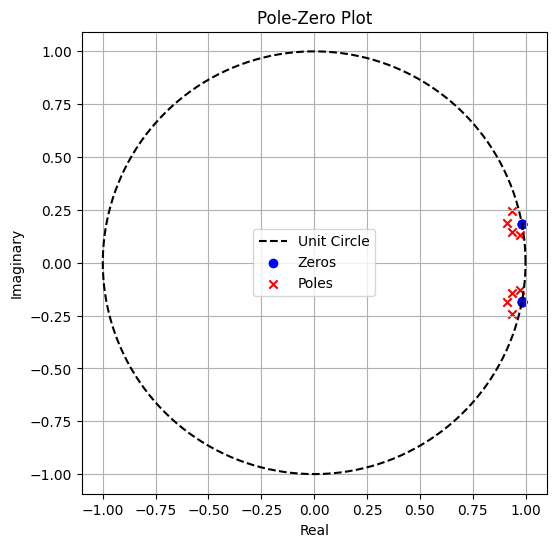

In [27]:
z, p, k = tf2zpk(b, a)  

# Plotting
plt.figure(figsize=(6, 6))
plt.title("Pole-Zero Plot")

# Unit circle
theta = np.linspace(0, 2 * np.pi, 500)
plt.plot(np.cos(theta), np.sin(theta), 'k--', label='Unit Circle')

# Zeros and poles
plt.scatter(np.real(z), np.imag(z), c='blue', marker='o', label='Zeros')
plt.scatter(np.real(p), np.imag(p), c='red', marker='x', label='Poles')

# Formatting
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.grid(True)
plt.axis('equal')
plt.legend()

Below is the Bode plot of the filter, which clearly shows:

* A strong attenuation (drop in magnitude) within the stopband (1000–2000 Hz).

* Smooth transitions in and out of the stopband.

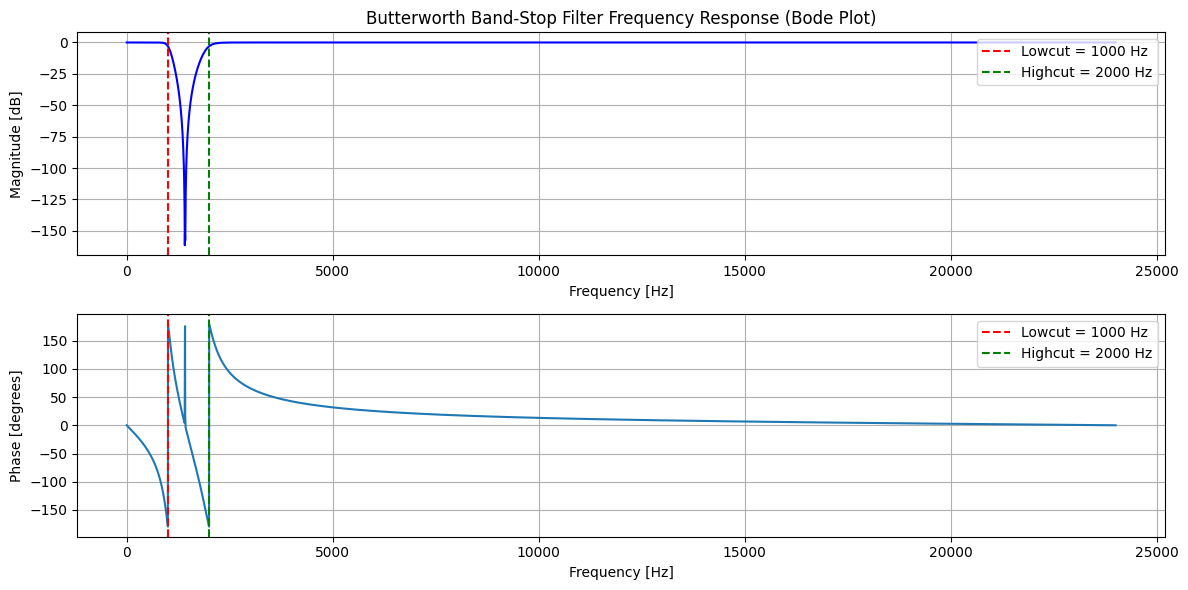

In [28]:
# Frequency response (Bode plot)
w, h = freqz(b, a, worN=8000)
frequencies = (w / np.pi) * (sr / 2)

plt.figure(figsize=(12, 6))

# Magnitude plot
plt.subplot(2, 1, 1)
plt.plot(frequencies, 20 * np.log10(abs(h)), 'b')
plt.axvline(lowcut, color='red', linestyle='--', label=f'Lowcut = {lowcut} Hz')
plt.axvline(highcut, color='green', linestyle='--', label=f'Highcut = {highcut} Hz')
plt.title('Butterworth Band-Stop Filter Frequency Response (Bode Plot)')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude [dB]')
plt.grid(True)
plt.legend(loc='upper right')

# Phase plot
plt.subplot(2, 1, 2)
plt.plot(frequencies, np.angle(h, deg=True))
plt.axvline(lowcut, color='red', linestyle='--',label=f'Lowcut = {lowcut} Hz')
plt.axvline(highcut, color='green', linestyle='--',label=f'Highcut = {highcut} Hz')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Phase [degrees]')
plt.grid(True)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


Now PSD of audio after applying band-stop filter

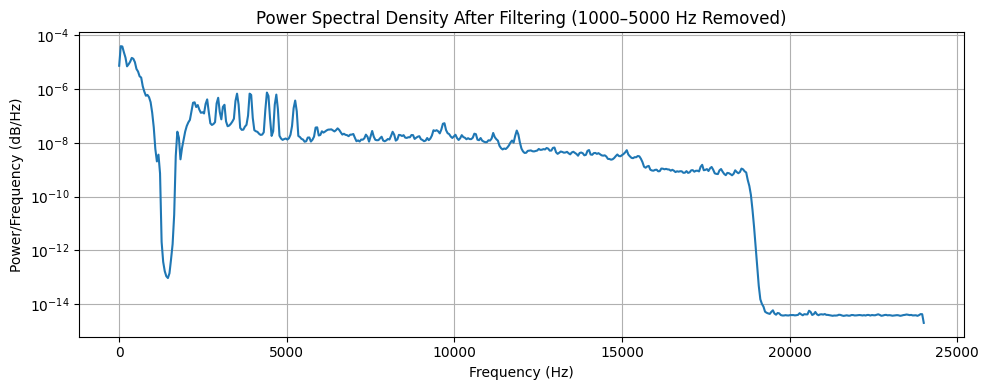

In [29]:


# Calculate PSD of filtered signal
f_filtered, Pxx_filtered = welch(y_butter_filtered, sr, nperseg=1024)

# Plot PSD
plt.figure(figsize=(10, 4))
plt.semilogy(f_filtered, Pxx_filtered)
plt.title("Power Spectral Density After Filtering (1000–5000 Hz Removed)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power/Frequency (dB/Hz)")
plt.grid(True)
plt.tight_layout()
plt.show()

In the PSD of filtered audio we can observe that:

* The frequency range between 1000 to 2000Hz shows a dip in power, which indicates successful supression of energy in that band.
* Filter has preserved the rest of audio of signal, as spectral content out of this range is unchanged.

## Further Refinement of Audio

Bandpass filter successfuly supressed the sharp peaks in PSD of unfiltered audio from range 1000Hz to 2000Hz, but there are still some unwanted sharp peaks from 2000 to 5000 Hz, 

### Approach 1

I took the fft of the signal, created mask (M(f)), which multiply the amplitude by 0.1, effectively reducing power by 90% in that range.

$$
M(f) =
\begin{cases}
0.1 & \text{if } 2000 \leq |f| \leq 5000 \\
1.0 & \text{otherwise}
\end{cases}
$$

Now we get the same audio as before, only the amplitude from 2000Hz to 5000Hz supressed, as we can se in PSD below 


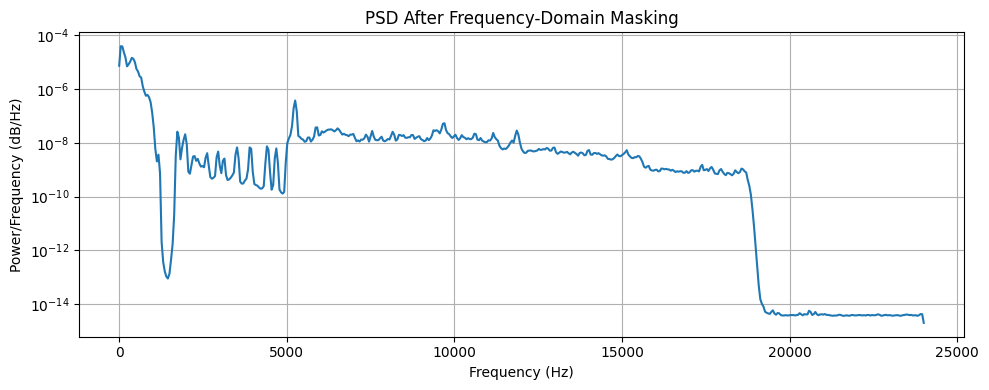

In [31]:
N = len(y_butter_filtered)
yf = fft(y_butter_filtered)
xf = fftfreq(N, 1 / sr)

mask = np.ones_like(yf)

for i in range(len(xf)):
    freq = abs(xf[i]) 
    if 2000 <= freq <= 5000:
        mask[i] *= 0.1   


yf_filtered = yf * mask
y_smoothed = np.real(ifft(yf_filtered))

f_smooth, Pxx_smooth = welch(y_smoothed, sr, nperseg=1024)

plt.figure(figsize=(10, 4))
plt.semilogy(f_smooth, Pxx_smooth)
plt.title("PSD After Frequency-Domain Masking")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power/Frequency (dB/Hz)")
plt.grid(True)
plt.tight_layout()
plt.show()


#### Output for the Approach 1

In [10]:
sf.write('output1.wav', y_smoothed, sr)

But output as you can listen is not so clear, since there is still piccolo sound in the audio which is quite irritating for the listener, so I decided to work on **Approach 2** to further filter out the piccolo sound.

### Approach 2

Made notch filter to filter out the piccolo sound, there are many small notch filter that are spaced every 80 Hz

Reason for applying notch filter: 

* I could have made one bandstop filter from 1000Hz to 5000Hz to filter out the frequency but that is not good for the audio, as it could have wiped out important content of the audio like vocals, etc along with noise.
* Because we're removing a broad chunk of mid-to-high frequencies, the sound may become lifeless, like we're hearing it through a wall or underwater, which might have degraded our sound
* Therefore I applied notch filter which are spaced every 80Hz of width 30Hz as Q = 30Hz, because of this we could retain our important part of sound

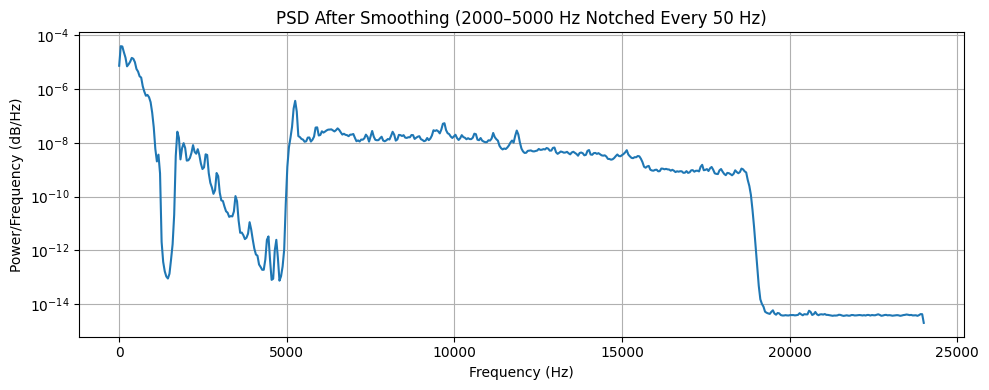

In [32]:



def notch_filter(f_center, fs, Q=30):  
    nyq = fs / 2
    bw = f_center / Q
    low = (f_center - bw / 2) / nyq
    high = (f_center + bw / 2) / nyq
    b, a = butter(N=2, Wn=[low, high], btype='bandstop')
    return b, a

residual_peaks = np.arange(2000, 5000 + 1, 80)

y_smoothed_final = y_butter_filtered.copy()
for freq in residual_peaks:
    b, a = notch_filter(freq, sr, Q=30)
    y_smoothed_final = filtfilt(b, a, y_smoothed_final)

# PSD plotting
f_smooth, Pxx_smooth = welch(y_smoothed_final, sr, nperseg=1024)

plt.figure(figsize=(10, 4))
plt.semilogy(f_smooth, Pxx_smooth)
plt.title("PSD After Smoothing (2000–5000 Hz Notched Every 50 Hz)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power/Frequency (dB/Hz)")
plt.grid(True)
plt.tight_layout()
plt.show()

### Bode plots for notch filter at specific frequency 3000 Hz of width 30 Hz

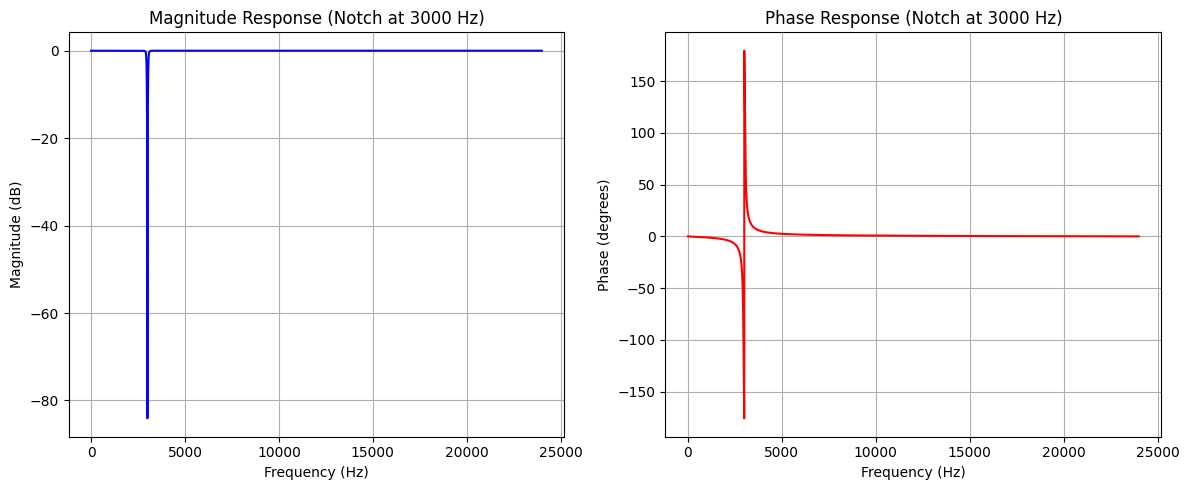

In [34]:
f_center = 3000
b, a = notch_filter(f_center, sr, Q=30)

w, h = freqz(b, a, worN=8000)
frequencies = w * sr / (2 * np.pi)

plt.figure(figsize=(12, 5))

# Magnitude Response
plt.subplot(1, 2, 1)
plt.plot(frequencies, 20 * np.log10(abs(h)), 'b')
plt.title(f'Magnitude Response (Notch at {f_center} Hz)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.grid()

# Phase Response
plt.subplot(1, 2, 2)
plt.plot(frequencies, np.angle(h, deg=True), 'r')
plt.title(f'Phase Response (Notch at {f_center} Hz)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Phase (degrees)')
plt.grid()

plt.tight_layout()
plt.show()

### Magnitude Spectrum of the signal 

* Blue: Original audio
* Orange: Butterworth Band-Stop Filtered Audio from 1000Hz to 2000Hz
* Green: Final Filtered Audio

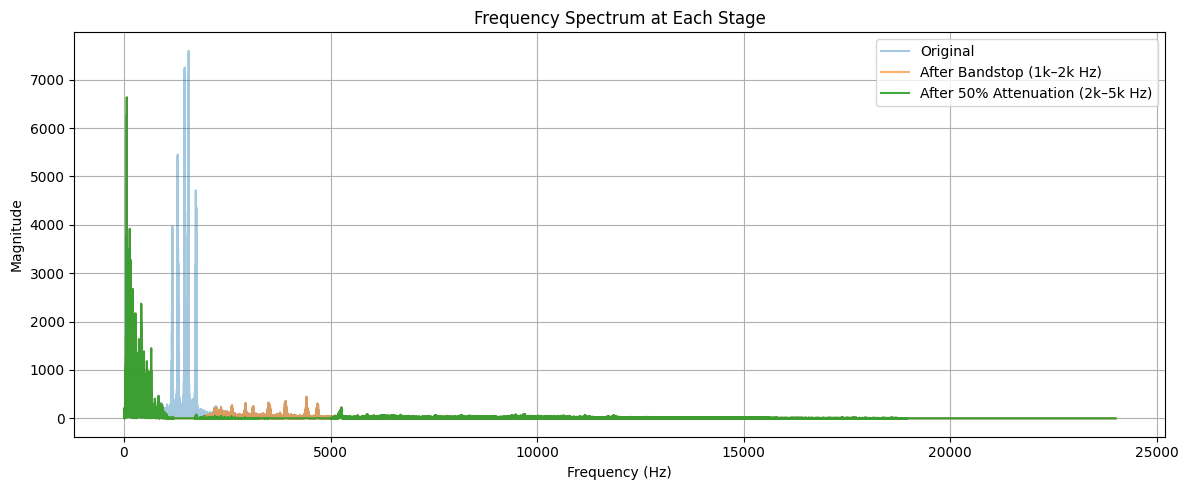

In [35]:
N = len(y_normalized)
freqs = fftfreq(N, d=1/sr)

# Compute FFTs for all 3 stages
fft_original = fft(y_normalized)
fft_after_bandstop = fft(y_butter_filtered)
fft_after_attenuation = fft(y_smoothed_final)

mag_original = np.abs(fft_original)
mag_bandstop = np.abs(fft_after_bandstop)
mag_final = np.abs(fft_after_attenuation)

# Plot of three spectra
plt.figure(figsize=(12, 5))
plt.plot(freqs[:N//2], mag_original[:N//2], label="Original", alpha=0.4)
plt.plot(freqs[:N//2], mag_bandstop[:N//2], label="After Bandstop (1k–2k Hz)", alpha=0.6)
plt.plot(freqs[:N//2], mag_final[:N//2], label="After 50% Attenuation (2k–5k Hz)", alpha=0.9)
plt.title("Frequency Spectrum at Each Stage")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### Waveform and Spectogram of the final output audio

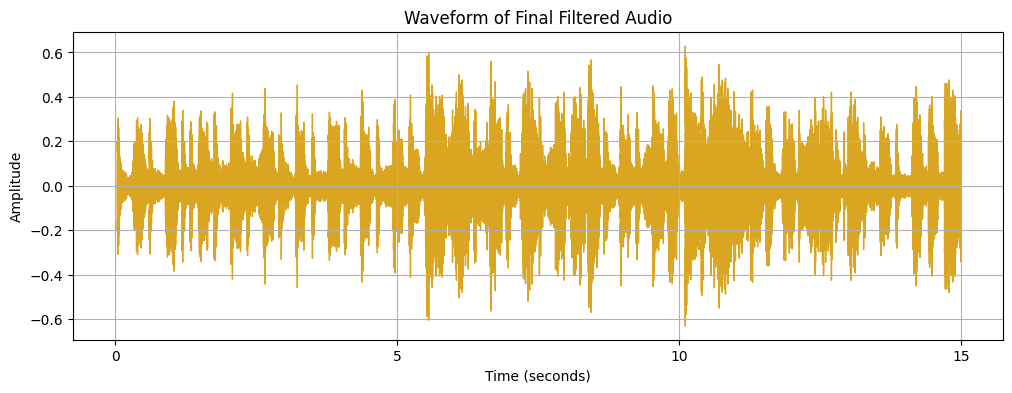

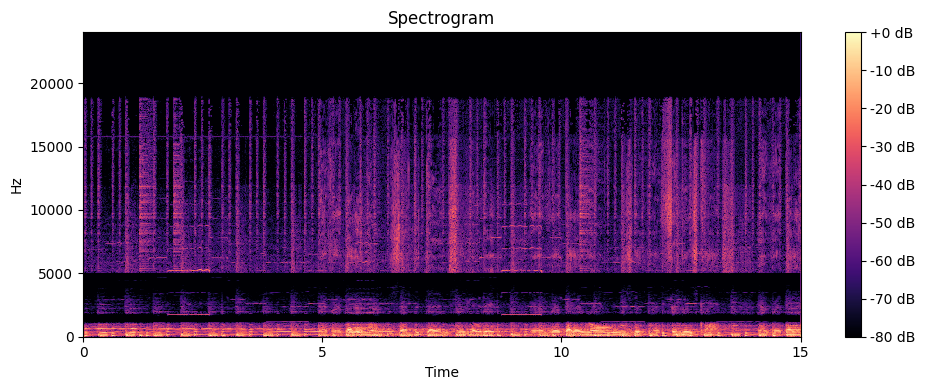

In [36]:
plt.figure(figsize=(12, 4))
librosa.display.waveshow(y_smoothed_final, sr=sr, color='goldenrod')
plt.title("Waveform of Final Filtered Audio")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.grid(True)

D = librosa.stft(y_smoothed_final)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

plt.figure(figsize=(10, 4))
librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='hz', cmap='magma')
plt.colorbar(format="%+2.0f dB")
plt.title("Spectrogram")
plt.tight_layout()
plt.show()

### Final output

In [37]:
sf.write('FinalFilteredAudio.wav', y_smoothed_final, sr)

# Conclusion

The frequency demixer assignment involves the following:
* I observed unwanted peaks in Power Spectral Density form range 1000Hz to 2000Hz, which I removed by using Butterworth Bandstop Filer.
* Then to further filter the audio, I followed two approach:
    * **Approach 1:** Where I decreased the power content of the frequency from range 2000Hz to 5000Hz by 90% by creating the mask function, but we didn't get that clear audio which is **output1.wav**
    * **Approach 2:** Then I performed another approach, to apply notch filter every 80 Hz of width 30Hz, which resulted more better audio that is **FinalFilteredAudio.wav**.

This shows how fourier transform, using different filters, can be used to filter the audio containing unwanted noise.